In [2]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from ironsilicate import IronSilicateEOS
from scipy import interpolate
from scipy import integrate

This reads the PhotometryPlanetRadiiSamplesRedo.csv file that I generated in USPRadiusDistribution.ipynb. It has 1000 radius samples for each USP planet. I make them all into a giant 62000-sample list that I can then slice for each planet.

In [83]:
periodsamples = []
radiisamples = []
kepids = []
meanearthradii = []
radiierrup = []
radiierrdown = []
per = []

## get 1000 planetary radius samples per planet, set up period array
with open('PhotometryPlanetRadiiSamplesRedo2.csv') as File:
    reader = csv.reader(File, delimiter=',')
    rownum = 0
    for row in reader:
        kepids.append(int(row[0]))
        samplelist = list(str(row[1]).split(','))
        samplelist[0] = samplelist[0][1:] # remove brackets
        samplelist[len(samplelist)-1] = samplelist[len(samplelist)-1][:-1] #remove brackets
        sampleslist = [float(i) for i in samplelist]
        meanearthradii.append(np.percentile(sampleslist, 50))
        ##earthradiierr.append(np.std(sampleslist))
        radiierrup.append(np.percentile(sampleslist, 15.85))
        radiierrdown.append(np.percentile(sampleslist, 84.15))
        radiisamples = radiisamples + sampleslist
        rownum += 1


In [84]:
print(len(kepids))
print(len(radiisamples))
print(meanearthradii)

62
62000
[1.4828595214497735, 1.1417693178784196, 1.299602052048148, 1.2494126410326891, 1.341555274362875, 1.4497973697926798, 1.367525658991736, 1.177115662137026, 1.4287650565338335, 1.197758706026557, 1.4376423448906706, 1.3748607503885488, 1.1964126286545085, 1.2054772586114626, 1.6777120973437811, 1.6381244702566227, 1.5085035078126272, 1.7523962699831843, 1.3771860868897927, 1.475721288556048, 1.138500652331357, 1.6502240500806409, 1.7370626082246239, 1.2965043359286446, 1.5480695353675142, 1.477953578818641, 1.1504360775718523, 0.9003409149640466, 0.9089832591243384, 1.5604521351254783, 1.103815423874319, 1.3077422209468512, 0.9698880580395954, 2.4109850247728475, 1.138400668552263, 1.8770164760504073, 1.164840204369851, 0.9024679748976583, 1.03228908387961, 1.4759154079466923, 0.7288173208418447, 1.3628332005798844, 1.506315265073694, 1.7119929460058647, 1.5804141723308331, 1.3537724881845694, 1.2649077618273505, 1.700772739537351, 1.7218430914569, 1.4392047108330575, 1.266630

Set up spherical integration

In [85]:
G = 6.67e-11
epsilon = 0.00001

Emass = 5.972e24 ## Earth mass
Erad = 6371000 ## Earth radius

P_cmb = np.logspace(8., 14., 32)
P_max_hat = np.logspace(0., 2., 32)


cmfarray = np.zeros((len(P_cmb), len(P_max_hat)))
crfarray = np.zeros_like(cmfarray)
planetmass = np.zeros_like(cmfarray)
planetrad = np.zeros_like(cmfarray)

In [86]:
Pcarr = []
rhos = []

for i in range(len(P_cmb)):
    for j in range(1, len(P_cmb)):
        
        Pcmb = P_cmb[i]
        eos = IronSilicateEOS(Pcmb, P_max_hat[j])
        Pc = eos.P_max
        Pcarr.append(Pc)
        
        def rho(P):
            return eos.eqnOfState(P)
        
        
        m0 = (4/3) * np.pi * rho(Pc) * (epsilon**3) ## initial mass
        P0 = Pc - (2/3) * np.pi * G * (rho(Pc)**2) * (epsilon**2) ## initial pressure
        
         ## change of variables where q = ln(P)
        def dmdq(q, m, r):
            P = np.exp(q)
            g = (G * m) / (r**2)
            return (-4 * P * np.pi * (r**2)) / g
        
        def drdq(q, m, r):
            P = np.exp(q)
            g = (G * m) / (r**2)
            return -P / (rho(P) * g)
            
        def fun(q, x):
            m, r = x
            return dmdq(q, m, r), drdq(q, m, r)
        
        q0 = np.log(P0)
        
        sol = integrate.solve_ivp(fun, t_span = (q0, 0), y0 = [m0, epsilon], method = 'LSODA', rtol = 0.5e-3, atol = 0.5e-6, max_step = .1)

        ## LSODA is the only integration method that works for this order of magnitude
        
        pressure = np.exp(sol.t)
        masses = sol.y[0]
        radii = sol.y[1]
        
        if i == 25 and j == 25:
             pre = np.exp(sol.t)
             mas = sol.y[0]
             rad = sol.y[1]
        
        

        # interpolate masses
        s = interpolate.interp1d(pressure, masses)
        coremass = s(Pcmb) # mass of core
        totalmass = s(1) # total planet mass
        cmf = coremass / totalmass # core mass fraction
        cmfarray[i][j] = cmf
        planetmass[i][j] = totalmass / Emass # in Earth masses
        
        # interpolate radii
        r = interpolate.interp1d(pressure, radii)
        corerad = r(Pcmb) # radius of core
        totalrad = r(1) # total radius
        crf = corerad / totalrad # core radius fraction
        crfarray[i][j] = crf
        planetrad[i][j] = totalrad / Erad # in Earth radii


Set up and flatten arrays for interpolation

In [88]:
Pcmbarray = np.zeros((len(P_cmb), len(P_cmb)))
Pmaxhatarray = np.zeros((len(P_cmb), len(P_cmb)))
for i in range(len(P_cmb)):
    for j in range(len(P_cmb)):
        Pcmbarray[i][j] = P_cmb[i]
        Pmaxhatarray[i][j] = P_max_hat[j]

In [89]:
flatrad = planetrad.flatten()
flatcmf = cmfarray.flatten()
flatPcmb = Pcmbarray.flatten()
flatPmaxhat = Pmaxhatarray.flatten()

getpcmb = interpolate.LinearNDInterpolator((flatrad, flatcmf), flatPcmb)
getpmaxhat = interpolate.LinearNDInterpolator((flatrad, flatcmf), flatPmaxhat)

getmass = interpolate.RegularGridInterpolator((P_cmb, P_max_hat), planetmass)

Interpolate massses. If the interpolation doesn't work for a sample, I put in a placeholder to maintain the order when slicing.

In [90]:
np.random.normal(0.33,0.1)

0.5323378102829301

In [91]:
earthmasssamples = []
i = 0
for radsample in radiisamples:
    try:
        earthmasssamples.append(getmass((getpcmb(radsample, 0.33), getpmaxhat(radsample, 0.33))))
        i = i + 1
    except:
        print("could not interpolate for sample", i)
        earthmasssamples.append(np.nan)
        i = i + 1

print("Mercury")
count = 0
mercurymasssamples = []
i = 0
for radsample in radiisamples:
    try:
        mercurymasssamples.append(getmass((getpcmb(radsample, 0.7), getpmaxhat(radsample, 0.7))))
        i = i + 1
    except:
        print("could not interpolate for sample", i)
        count += 1
        mercurymasssamples.append(np.nan)
        i = i + 1
    
        
randmasssamples = []
i = 0
for radsample in radiisamples:
    randomcmf = np.random.normal(0.33,0.1)
    while (randomcmf <= 0):
        randomcmf = np.random.normal(0.33,0.1)
    try:
        randmasssamples.append(getmass((getpcmb(radsample, randomcmf), getpmaxhat(radsample, randomcmf))))
        i = i + 1
    except:
        print("could not interpolate for sample", i, "cmf = ", randomcmf)
        randmasssamples.append(np.nan)
        i = i + 1

print(count)

Mercury
could not interpolate for sample 33024
could not interpolate for sample 33029
could not interpolate for sample 33047
could not interpolate for sample 33142
could not interpolate for sample 33143
could not interpolate for sample 33171
could not interpolate for sample 33195
could not interpolate for sample 33240
could not interpolate for sample 33277
could not interpolate for sample 33319
could not interpolate for sample 33400
could not interpolate for sample 33415
could not interpolate for sample 33430
could not interpolate for sample 33436
could not interpolate for sample 33443
could not interpolate for sample 33467
could not interpolate for sample 33512
could not interpolate for sample 33547
could not interpolate for sample 33561
could not interpolate for sample 33573
could not interpolate for sample 33602
could not interpolate for sample 33644
could not interpolate for sample 33696
could not interpolate for sample 33700
could not interpolate for sample 33727
could not interpo

In [92]:
print(kepids[33])
print(len(randmasssamples))
print(len(mercurymasssamples))

8895758
62000
62000


In [93]:
meanearthmasses = []
eartherrup = []
eartherrdown = []

meanmercmasses = []
mercerrup = []
mercerrdown = []

meanrandmasses = []
randerrup = []
randerrdown = []


file = open('EarthlikeMassSamples.csv', 'w')
with file:
    writer = csv.writer(file)
    for i in range(0, (len(earthmasssamples) // 1000)):
        list1 = []
        list1 = earthmasssamples[(1000*i) : (1000*(i+1)) - 1]
        for f in list1:
            if np.isnan(f):
                list1.remove(f)
                print("removed")
        meanearthmasses.append(np.percentile(list1, 50))
        ##eartherr.append(np.std(list1))
        eartherrup.append(np.percentile(list1, 15.85))
        eartherrdown.append(np.percentile(list1, 84.15))
        row = [kepids[i]]
        for k in range(0, len(list1)):
            row.append(list1[k])
        writer.writerow(row)
        
count = 0
file = open('MercuryLikeMassSamples.csv', 'w')
with file:
    writer = csv.writer(file)
    for i in range(0, (len(mercurymasssamples) // 1000)):
        list1 = []
        list1 = mercurymasssamples[(1000*i) : (1000*(i+1)) - 1]
        for f in list1:
            if np.isnan(f):
                list1.remove(f)
                count += 1
                print("removed")
        meanmercmasses.append(np.percentile(list1, 50))
        mercerrup.append(np.percentile(list1, 15.85))
        mercerrdown.append(np.percentile(list1, 84.15))
        ##mercerr.append(np.std(list1))
        row = [kepids[i]]
        for k in range(0, len(list1)):
            row.append(list1[k])
        writer.writerow(row)
        ##print(i)
        
file = open('RandomCMFMassSamples.csv', 'w')
with file:
    writer = csv.writer(file)
    for i in range(0, (len(randmasssamples) // 1000)):
        list1 = []
        list1 = randmasssamples[(1000*i) : (1000*(i+1)) - 1]
        for f in list1:
            if np.isnan(f):
                list1.remove(f)
                print("removed")
        meanrandmasses.append(np.percentile(list1, 50))
        randerrup.append(np.percentile(list1, 15.85))
        randerrdown.append(np.percentile(list1, 84.15))
        randerr.append(np.std(list1))
        row = [kepids[i]]
        for k in range(0, len(list1)):
            row.append(list1[k])
        writer.writerow(row)
        
print(count)

removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed
removed


/Users/anasofiauzsoy/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


removed
removed
34


In [94]:
print(meanmercmasses)

[6.783658339835074, 2.514625459287655, 4.054361979649752, 3.552569379771298, 4.640067676420764, 6.215871676395129, 5.002750695799228, 2.8268360512995905, 5.951792954255794, 3.0357984831217126, 6.063884404938335, 5.117530124600816, 3.0235258328613717, 3.109722411725609, 11.374738124631909, 10.19479014928401, 7.306490115598811, 13.521326882271643, 5.155232817449441, 6.648572230537914, 2.4932450766119723, 10.557328139799283, 13.085723233377976, 4.024468624928613, 8.163917385411494, 6.692439547797676, 2.5706965481333386, 1.0687187621115515, 1.1121897211427763, 8.431601817701592, 2.2440983772081995, 4.153318650026964, 1.406486705887822, nan, 2.4925600364209712, 18.396070239931667, 2.7050582071546305, 1.0797619111362469, 1.7487700348951316, 6.647255582689252, 0.5102550710249725, 4.9312129915838305, 7.259876470893989, 12.378902188456804, 8.86438389782556, 4.8033768381787745, 3.7178095684379837, 12.061845591476182, 12.657217737177836, 6.08564375463818, 3.7358846129457817, 1.73693776747214, 13.

In [96]:
print(eartherrup)

[3.160506685430703, 1.4836839381066373, 2.417768235790845, 2.2018036642860497, 2.4678660206502903, 3.266136562649007, 2.6964389109374354, 1.5168799617053756, 3.5519377510341763, 1.7105752530606475, 3.388774023224226, 3.111783871942734, 1.8432803777823508, 1.6384739589513018, 6.05534468400341, 5.679492929771847, 4.368157208418457, 7.614346825153816, 2.9611558241540226, 3.580545205485767, 1.4440193138201145, 4.906504709137234, 6.883991492038332, 2.5182658349215092, 4.563812348591227, 4.103218467131933, 1.535265913941176, 0.5042614377972685, 0.6277008808623772, 4.552874410316898, 1.237169277502689, 1.892735557903098, 0.8190698031951397, 11.924005900379617, 1.4426371185084474, 9.198863400571122, 1.636692557784568, 0.6848936245208296, 0.9077713982660928, 3.67595075493176, 0.3219649778215685, 2.4666924033809585, 4.390968659875562, 6.916811814548536, 5.199657527457143, 2.6031544131028355, 2.017631924738663, 6.684911549480258, 7.435277428526472, 3.584156103902036, 2.273060856401815, 1.06179117

In [97]:
meanplanradband = [1.5142207897134599, 1.1436702581725311, 1.29995494508817, 1.3189668428623589, 1.2269233123544596, 1.3416469177901493, 1.4501086309196631, 1.1346210885160928, 1.3678308145394535, 1.1773182912719149, 1.4290130565850703, 1.1924524835284092, 1.4377185513117101, 1.3778832575370645, 1.1987523431558333, 1.2031537496435152, 1.6789372289268041, 1.6367597521676016, 1.5102166858962964, 1.2450243555135487, 1.7554218547394591, 1.3750204896572571, 1.4763165953082957, 1.1374076117298841, 1.6579424766739201, 1.7474079535815623, 1.2976710643762763, 1.5469721327227073, 1.4803792515077325, 1.1485935543428036, 0.91107113014034191, 0.90912534283711122, 1.5575626745682334, 1.1016976539308982, 1.306567461499029, 0.97216101853985515, 2.3659198651407789, 1.1388767324032376, 1.8878774237581295, 1.1603625846498211, 0.90433911227498831, 1.0330717061012351, 1.4773091465919181, 0.72919497667200817, 1.3558223565388077, 1.5039103713589141, 1.7185699399360876, 1.5759094919342289, 1.3535027097987864, 1.2676025968602689, 1.6999474483312145, 1.7232645141015186, 1.4375272444998766, 1.2675926110963895, 1.0322004078256348, 1.742165191417018, 1.5358602614962091, 1.4630747310708188, 1.3776544531211727, 1.0864475036950445, 1.2169836268301546, 1.4158706344921796, 1.025515766195459, 2.5964514405645982, 0.98803480896675566, 1.3933339279057437, 1.7206936810871374, 1.5010015006680679, 1.4465641351682894, 1.0878734373223826, 1.5076561842415757]

radsss = []
massss = []
cmfsss = []

for i in range(len(planetrad[0])):
    for j in range(len(planetrad)):
        radsss.append(planetrad[i][j])
        massss.append(planetmass[i][j])
        cmfsss.append(cmfarray[i][j])

/Users/anasofiauzsoy/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


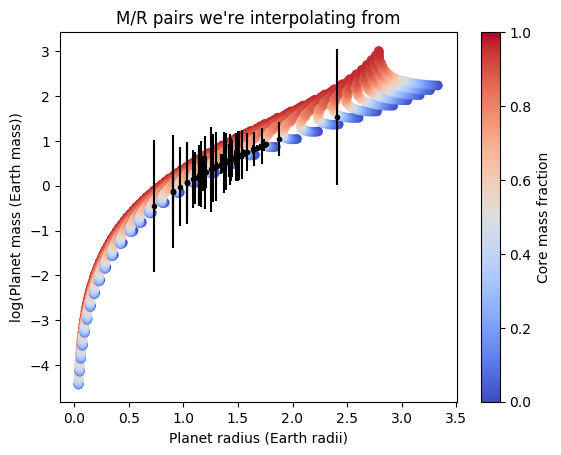

In [98]:
cm = plt.cm.get_cmap('coolwarm')
sc = plt.scatter(radsss, np.log10(massss), c = cmfsss, vmin = 0., vmax = 1., cmap = cm)
plt.plot(meanearthradii, np.log10(meanearthmasses),'k.')
plt.errorbar(meanearthradii, np.log10(meanearthmasses),ls= 'none',yerr = np.log10(eartherr), ecolor = 'k')
plt.colorbar(sc, label = "Core mass fraction")
plt.xlabel("Planet radius (Earth radii)")
plt.ylabel("log(Planet mass (Earth mass))")
plt.title("M/R pairs we're interpolating from")
plt.show()

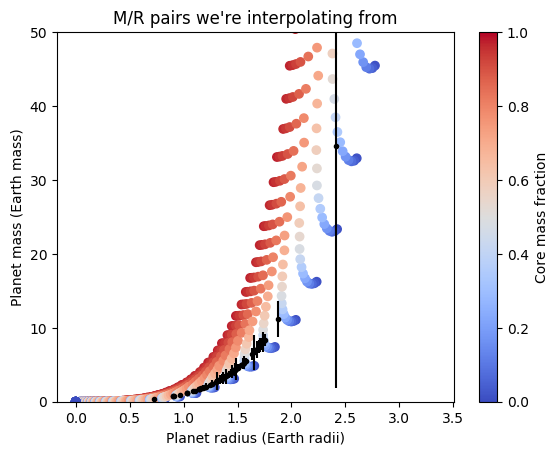

In [99]:
cm = plt.cm.get_cmap('coolwarm')
sc = plt.scatter(radsss, massss, c = cmfsss, vmin = 0., vmax = 1., cmap = cm)
plt.plot(meanearthradii, meanearthmasses,'k.')
plt.errorbar(meanearthradii, meanearthmasses, ls= 'none',yerr = eartherr, ecolor = 'k')
plt.colorbar(sc, label = "Core mass fraction")
plt.xlabel("Planet radius (Earth radii)")
plt.ylabel("Planet mass (Earth mass)")
plt.title("M/R pairs we're interpolating from")
plt.ylim(0, 50)
plt.show()

In [100]:
kepids.index(11600889)

50

In [102]:
print(meanearthmasses[50])
print(eartherrup[50])
print(eartherrdown[50])

2.461440618486861
2.273060856401815
2.6343548832752433


In [103]:
kepid = []
koi = []
adivr = []
per = []
starrad = []
pradii = []
numstars = []


with open('USPHostProperties.csv') as File:
     reader = csv.reader(File, delimiter=',')
     rownum = 0
     for row in reader:
         if rownum > 0:
             kepid.append(int(row[0]))
             koi.append(int(row[1]))
             adivr.append(float(row[2]))
             per.append(float(row[3]))
             starrad.append(float(row[11]))
             pradii.append(float(row[12]))
             numstars.append(float(row[13]))
         rownum += 1

falsepositives = [4929299, 10527135, 5642620, 12170648, 3834322,6750902,7269881,10186945,12115188]

todelete = []
for j in range(0,len(falsepositives)):
    for i in range(0, len(kepid)):
        if kepid[i] == falsepositives[j]:
            todelete.append(i)
            
todelete.reverse()
for k in todelete:
    del kepid[k]
    del koi[k]
    del per[k]
    del adivr[k]
    del numstars[k]
    
adivr = [adivr[i] for i in range(0,len(kepid)) if kepid[i] != 11030475]
per = [per[i] for i in range(0,len(kepid)) if kepid[i] != 11030475]
numstars = [numstars[i] for i in range(0,len(kepid)) if kepid[i] != 11030475]
print(len(per))
print(len(numstars))

periodsamples = []
for i in range(0, len(radiisamples)):
    periodsamples.append(per[i//1000])
    
print(len(periodsamples))

62
62
62000


In [104]:
import seaborn as sns

radbins = [0.5,(1/np.sqrt(2)),1,np.sqrt(2),2,2*np.sqrt(2),4]
radbinsflip = np.flip(radbins,0) ## makes orientation correct on y axis

perbins = [4,4*(6**0.25),4*np.sqrt(6),4*(6**0.75),24]
array = np.zeros((len(radbins)-1,len(perbins)-1))
scaledarray = np.zeros((len(radbins)-1,len(perbins)-1))
freqarray = np.zeros((len(radbins)-1,len(perbins)-1))

## calculates occurrence rate contribution for each planet sample
f = [(adivr[i]/numstars[i]) for i in range(0,len(kepid))]

kepid2 = []

for i in range(len(periodsamples)):
    for j in range(len(perbins)-1):
        for k in range(len(radbins)-1):
            if (perbins[j] <= 24*periodsamples[i] <= perbins[j+1]) and (radbinsflip[k] >= radiisamples[i] >= radbinsflip[k+1]):
                array[k][j] += (f[per.index(periodsamples[i])])/1000
                freqarray[k][j] += 1

print(array * 1000) ## number of planets per 1000 stars
print(freqarray)

for j in range(0,len(perbins)-1):
    for i in range(0,len(radbins)-1):
        if array[i][j] != 0:
            scaledarray[i][j] = 1 + (np.log10(array[i][j]/(5*(10**-9)))) # moved up by 1 to make way for zero.
        if array[i][j] == 0:
            scaledarray[i][j] = 1 + -1
        
print(scaledarray)

## convert period to hours
per2 = [24 * i for i in per]

f2 = [(1/numstars[i]) for i in range(0,len(kepid))]

transitarray = np.zeros((len(radbins)-1,len(perbins)-1))

for i in range(len(periodsamples)):
    for j in range(len(perbins)-1):
        for k in range(len(radbins)-1):
            if (perbins[j] <= 24*periodsamples[i] <= perbins[j+1]) and (radbinsflip[k] >= radiisamples[i] >= radbinsflip[k+1]):
                transitarray[k][j] += (f2[per.index(periodsamples[i])])/1000

## calculate 68.3% Wilson Confidence Interval
wilsonhigh = np.empty((len(radbins)-1,len(perbins)-1), dtype = object)
wilsonlow = np.empty((len(radbins)-1,len(perbins)-1), dtype = object)
wilson3d = np.empty((len(radbins)-1,len(perbins)-1,2))
for i in range(len(radbins)-1):
    for j in range(len(perbins)-1):
        if transitarray[i][j] == 0:
            wilsonhigh[i][j] = "N=0"
            wilsonlow[i][j] = "N=0"
        else:
            n = (freqarray[i][j])/(transitarray[i][j])
            if n == 0:
                wilsonhigh[i][j] = "n=0"
                wilsonlow[i][j] = "n=0"
            else:
                z = 0.41
                high = ((transitarray[i][j] + (z**2)/(2*n))/(1+(z**2)/n)) + (z/(1+((z**2)/n)))*np.sqrt(((transitarray[i][j]*(1-transitarray[i][j]))/n)-((z**2)/(4*(n**2))))
                low = ((transitarray[i][j] - (z**2)/(2*n))/(1+(z**2)/n)) - (z/(1+((z**2)/n)))*np.sqrt(((transitarray[i][j]*(1-transitarray [i][j]))/n)-((z**2)/(4*(n**2))))
                wilsonhigh[i][j] = (1000 * (array[i][j]/transitarray[i][j])*high) - 1000*array[i][j]
                wilsonlow[i][j] = (1000 * (array[i][j]/transitarray[i][j])*low) - 1000*array[i][j]
                wilson3d[i][j] = [low,high]

print("high")
print(wilsonhigh)
print("low")
print(wilsonlow)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 9.25615987e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 8.07246184e-02]
 [6.27843295e-02 2.37650689e-02 3.97967958e-01 1.13866846e+00]
 [5.94954311e-02 2.18795506e-01 3.39824485e-01 1.65368432e+00]
 [0.00000000e+00 1.41777498e-03 6.76231204e-02 1.10659849e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 5.09635983e-02]]
[[0.0000e+00 0.0000e+00 0.0000e+00 8.6000e+01]
 [0.0000e+00 0.0000e+00 0.0000e+00 8.1000e+02]
 [8.6400e+02 9.1000e+02 7.9200e+03 1.7945e+04]
 [1.1360e+03 4.0780e+03 5.2640e+03 1.7575e+04]
 [0.0000e+00 1.2000e+01 8.1600e+02 4.4310e+03]
 [0.0000e+00 0.0000e+00 0.0000e+00 1.5100e+02]]
[[0.         0.         0.         4.26746084]
 [0.         0.         0.         5.208036  ]
 [5.09888126 4.67696907 5.9008781  6.35742729]
 [5.07551361 5.64106839 5.83228466 6.5194826 ]
 [0.         3.4526373  5.1311252  6.34502007]
 [0.         0.         0.         5.00829008]]
high
[['N=0' 'N=0' 'N=0' 0.0004181739739919227]
 ['N=0'

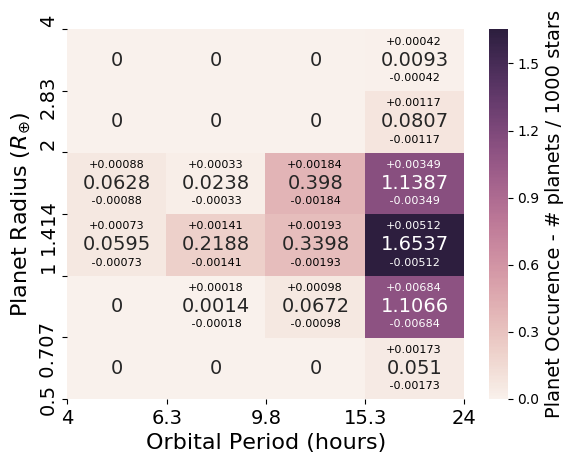

In [105]:
labels = np.array([[0,0,0,0.0093],[0,0,0,0.0807],[0.0628,0.0238,0.3980,1.1387],[0.0595,0.2188,0.3398,1.6537],[0,0.0014,0.0672,1.1066],[0,0,0,0.0510]],dtype = object)
fig, ax = plt.subplots()
ax = sns.heatmap(1000*array, annot = labels, fmt = '', annot_kws={"size": 14})
plt.text(3.21,5.75,"+0.00042", size = 8)
plt.text(3.21,5.16," -0.00042", size = 8)
plt.text(3.21,4.75,"+0.00117", size = 8)
plt.text(3.21,4.16," -0.00117", size = 8)
plt.text(0.21,3.75,"+0.00088", size = 8)
plt.text(0.21,3.16," -0.00088", size = 8)
plt.text(1.21,3.75,"+0.00033", size = 8)
plt.text(1.21,3.16," -0.00033", size = 8)
plt.text(2.21,3.75,"+0.00184", size = 8)
plt.text(2.21,3.16," -0.00184", size = 8)
plt.text(3.21,3.75,"+0.00349", color = 'w', size = 8)
plt.text(3.21,3.16," -0.00349", color = 'w', size = 8)
plt.text(0.21,2.75,"+0.00073", size = 8)
plt.text(0.21,2.16," -0.00073", size = 8)
plt.text(1.21,2.75,"+0.00141", size = 8)
plt.text(1.21,2.16," -0.00141", size = 8)
plt.text(2.21,2.75,"+0.00193", size = 8)
plt.text(2.21,2.16," -0.00193", size = 8)
plt.text(3.21,2.75,"+0.00512", color = 'w', size = 8)
plt.text(3.21,2.16," -0.00512", color = 'w', size = 8)
plt.text(1.21,1.75,"+0.00018", size = 8)
plt.text(1.21,1.16," -0.00018", size = 8)
plt.text(2.21,1.75,"+0.00098", size = 8)
plt.text(2.21,1.16," -0.00098", size = 8)
plt.text(3.21,1.75,"+0.00684", color = 'w', size = 8)
plt.text(3.21,1.16," -0.00684", color = 'w', size = 8)
plt.text(3.21,0.75,"+0.00173", size = 8)
plt.text(3.21,0.16," -0.00173", size = 8)
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels([4,6.3,9.8,15.3,24], fontsize = 14)
ax.set_yticks([0,1,2,3,4,5,6])
ax.set_yticklabels([0.5," 0.707",1,1.414,2,2.83,4], fontsize = 14, horizontalalignment = 'right', verticalalignment = 'baseline')
cbar = ax.collections[0].colorbar
cbar.set_label('Planet Occurence - # planets / 1000 stars', fontsize = 14)
plt.xlabel("Orbital Period (hours)", fontsize = 16)
plt.ylabel("Planet Radius ($R_{\oplus}$)", fontsize = 16)

plt.show()

For Kepler-10b, the measured mass is 3.72 +/- 0.42 Earth masses. For Kepler-78b, the measured mass is 1.82 +/- 0.27 Since I use the orbital periods in the occurrence rate calculations, I'm going to identify these by its orbital period.

In [106]:
import scipy.stats
dist10 = scipy.stats.norm(3.72, 0.42)
dist78 = scipy.stats.norm(1.82, 0.27)

kep10kic = 11904151
kep10per = per[kepid.index(11904151)]
print(kep10per)

kep78per = per[kepid.index(8435766)]
print(kep78per)

print(dist10.pdf(3.5))

0.8374906
0.35500753
0.828096012563806


In [107]:
for i in range(0, len(per)):
    for j in range(0, len(per)):
        if (per[i] == per[j] and i != j):
            print("yes")

len massrand 62


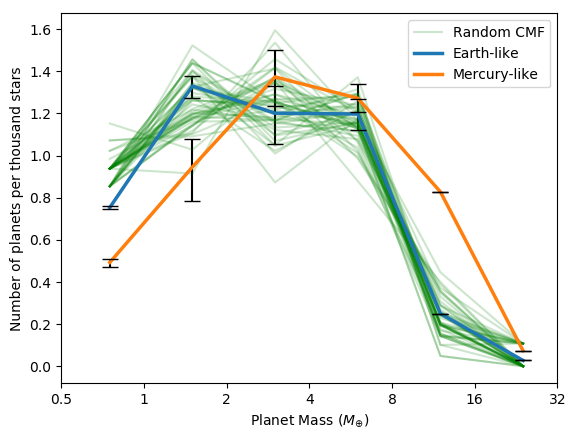

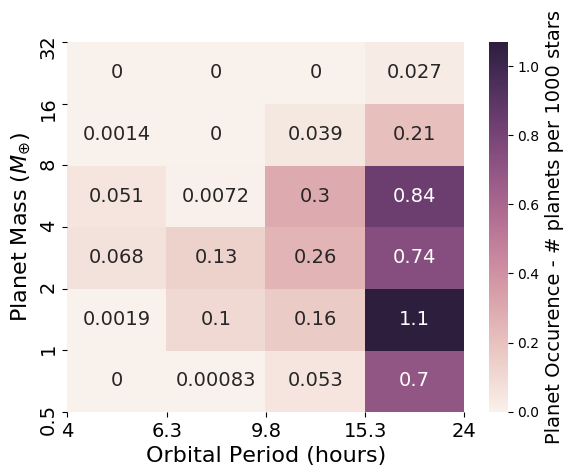

In [108]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.pyplot as plt
earthsamples = []
earthperiodsamples = []
## open mass samples file, calculate occurrence rates, set up period array
with open('EarthlikeMassSamples.csv') as File:
     reader = csv.reader(File, delimiter=',')
     rownum = 0
     for row in reader:
         kepid2 = (int(row[0]))
         samplelist = []
         for i in range(len(row) - 1):
             samplelist.append(float(row[i]))
         for i in range(len(samplelist)):
             earthperiodsamples.append(float(per[kepid.index(kepid2)]))
         earthsamples = earthsamples + samplelist
         rownum += 1

mercurysamples = []
mercperiodsamples = []
## open mass samples file, calculate occurrence rates, set up period array
with open('MercuryLikeMassSamples.csv') as File:
     reader = csv.reader(File, delimiter=',')
     rownum = 0
     for row in reader:
         kepid2 = (int(row[0]))
         samplelist = []
         for i in range(len(row) - 1):
             samplelist.append(float(row[i]))
         for i in range(len(samplelist)):
             mercperiodsamples.append(float(per[kepid.index(kepid2)]))
         mercurysamples = mercurysamples + samplelist
         rownum += 1

randsamples = []
massrand = []
randperiodsamples = []
## open mass samples file, calculate occurrence rates, set up period array
with open('RandomCMFMassSamples.csv') as File:
     reader = csv.reader(File, delimiter=',')
     rownum = 0
     for row in reader:
         kepid2 = (int(row[0]))
         samplelist = []
         for i in range(len(row) - 1):
             samplelist.append(float(row[i]))
         for i in range(len(samplelist)):
             randperiodsamples.append(float(per[kepid.index(kepid2)]))
         massrand.append(np.percentile(list1, 50))
         randsamples = randsamples + samplelist
         rownum += 1

print("len massrand", len(massrand))

radbins = [0.5,(1/np.sqrt(2)),1,np.sqrt(2),2,2*np.sqrt(2),4]
massbins = [0.5,1,2,4,8,16,32]
perbins = [4,4*(6**0.25),4*np.sqrt(6),4*(6**0.75),24]

massarray = np.zeros((len(massbins)-1,len(perbins)-1))

massbinsflip = np.flip(massbins,0)

f = [(adivr[i]/numstars[i]) for i in range(0,len(kepid))]
f2 = [(1/numstars[i]) for i in range(0,len(kepid))]

## sum occurrence rate in bins

earthmasstransitarray = np.zeros((len(radbins)-1,len(massbins)-1))
mercmasstransitarray = np.zeros((len(radbins)-1,len(massbins)-1))
mercfreqarray = np.zeros((len(radbins)-1,len(massbins)-1))
earthfreqarray = np.zeros((len(radbins)-1,len(massbins)-1))

for i in range(len(massrand)):
    for j in range(len(perbins)-1):
        for k in range(len(massbins)-1):
            if (perbins[j] <= 24*randperiodsamples[i] <= perbins[j+1]) and (massbinsflip[k] >= massrand[i] >= massbinsflip[k+1]):
                massarray[k][j] += (f[i])
                
kep10sumearth = 0
kep78sumearth = 0
earthweighted78sum = 0
earthweighted10sum = 0
eartharray = np.zeros((len(massbins)-1,len(perbins)-1))
for i in range(len(earthperiodsamples)):
    for j in range(len(perbins)-1):
        for k in range(len(massbins)-1):
            if (perbins[j] <= 24*earthperiodsamples[i] <= perbins[j+1]) and (massbinsflip[k] >= earthsamples[i] >= massbinsflip[k+1]):
                eartharray[k][j] += (f[per.index(earthperiodsamples[i])])/1000
                earthmasstransitarray[k][j] += (f2[per.index(earthperiodsamples[i])])/1000
                earthfreqarray[k][j] += 1/1000
                if (earthperiodsamples[i] == kep10per):
                    kep10sumearth += (f[per.index(earthperiodsamples[i])])/1000
                    earthweighted10sum += ((f[per.index(earthperiodsamples[i])])/1000 *  dist10.pdf(earthsamples[i]))
                if (earthperiodsamples[i] == kep78per):
                    kep78sumearth += (f[per.index(earthperiodsamples[i])])/1000
                    earthweighted78sum += ((f[per.index(earthperiodsamples[i])])/1000 *  dist78.pdf(earthsamples[i]))

                
kep10summerc = 0    
kep78summerc = 0 
mercweighted78sum = 0
mercweighted10sum = 0
mercuryarray = np.zeros((len(massbins)-1,len(perbins)-1))
for i in range(len(mercperiodsamples)):
    for j in range(len(perbins)-1):
        for k in range(len(massbins)-1):
            if (perbins[j] <= 24*mercperiodsamples[i] <= perbins[j+1]) and (massbinsflip[k] >= mercurysamples[i] >= massbinsflip[k+1]):
                mercuryarray[k][j] += (f[per.index(mercperiodsamples[i])])/1000
                mercmasstransitarray[k][j] += (f2[per.index(mercperiodsamples[i])])/1000
                mercfreqarray[k][j] += 1/1000
                if (mercperiodsamples[i] == kep10per):
                    kep10summerc += (f[per.index(mercperiodsamples[i])])/1000
                    mercweighted10sum += ((f[per.index(mercperiodsamples[i])])/1000 *  dist10.pdf(mercurysamples[i]))

                if (mercperiodsamples[i] == kep78per):
                    kep78summerc += (f[per.index(mercperiodsamples[i])])/1000
                    mercweighted78sum += ((f[per.index(mercperiodsamples[i])])/1000 *  dist78.pdf(mercurysamples[i]))

    
    
earthmasssum = np.zeros(len(massbins)-1)   
mercmasssum = np.zeros(len(massbins)-1) 
masssum = np.zeros(len(massbins)-1)  

merctransitsum = np.zeros(len(massbins)-1) 
earthtransitsum = np.zeros(len(massbins)-1) 

mercfreqsum = np.zeros(len(massbins)-1) 
earthfreqsum = np.zeros(len(massbins)-1) 
for j in range(len(massbins) - 1):
    for i in range(len(perbins)-1):
        masssum[j] += massarray[j][i]*1000
        earthmasssum[j] += eartharray[j][i]*1000
        mercmasssum[j] += mercuryarray[j][i]*1000
        earthtransitsum[j] += earthmasstransitarray[i][j] * 1000
        merctransitsum[j] += mercmasstransitarray[i][j] * 1000
        mercfreqsum[j] += mercfreqarray[i][j]
        earthfreqsum[j] += earthfreqarray[i][j]
        

massticks = np.zeros(len(massbins)-1) 
for i in range(len(massbins)-1):
    massticks[i] = np.log2((massbins[i+1] + massbins[i])/2)
         

       
earthwilsonhigh = np.zeros(len(massbins)-1,dtype = object) 
earthwilsonlow = np.zeros(len(massbins)-1,dtype = object) 
for i in range(len(massbins)-1):
    if earthtransitsum[i] == 0:
        earthwilsonhigh[i] = "N=0"
        earthwilsonlow[i] = "N=0"
    else:
        n = (earthfreqsum[i])/(earthtransitsum[i])
        if n == 0:
            earthwilsonhigh[i] = "n=0"
            earthwilsonlow[i] = "n=0"
        else:
            z = 0.41
            high = ((earthtransitsum[i] + (z**2)/(2*n))/(1+(z**2)/n)) + (z/(1+((z**2)/n)))*np.sqrt(((earthtransitsum[i]*(1-earthtransitsum[i]))/n)-((z**2)/(4*(n**2))))
            low = ((earthtransitsum[i] + (z**2)/(2*n))/(1+(z**2)/n)) - (z/(1+((z**2)/n)))*np.sqrt(((earthtransitsum[i]*(1-earthtransitsum[i]))/n)-((z**2)/(4*(n**2))))
            earthwilsonhigh[i] = ((earthmasssum[i]/earthtransitsum[i])*high) - earthmasssum[i]
            earthwilsonlow[i] = ((earthmasssum[i]/earthtransitsum[i])*low) - earthmasssum[i]

mercwilsonhigh = np.zeros(len(massbins)-1,dtype = object) 
mercwilsonlow = np.zeros(len(massbins)-1,dtype = object) 
for i in range(len(massbins)-1):
    if merctransitsum[i] == 0:
        mercwilsonhigh[i] = "N=0"
        mercwilsonlow[i] = "N=0"
    else:
        n = (mercfreqsum[i])/(merctransitsum[i])
        if n == 0:
            mercwilsonhigh[i] = "n=0"
            mercwilsonlow[i] = "n=0"
        else:
            z = 0.41
            high = ((merctransitsum[i] + (z**2)/(2*n))/(1+(z**2)/n)) + (z/(1+((z**2)/n)))*np.sqrt(((merctransitsum[i]*(1-merctransitsum[i]))/n)-((z**2)/(4*(n**2))))
            low = ((merctransitsum[i] + (z**2)/(2*n))/(1+(z**2)/n)) - (z/(1+((z**2)/n)))*np.sqrt(((merctransitsum[i]*(1-merctransitsum[i]))/n)-((z**2)/(4*(n**2))))
            mercwilsonhigh[i] = ((mercmasssum[i]/merctransitsum[i])*high) - mercmasssum[i]
            mercwilsonlow[i] = ((mercmasssum[i]/merctransitsum[i])*low) - mercmasssum[i]


eartherrorup = np.zeros(len(massbins)-1)
eartherrordown = np.zeros(len(massbins)-1)
mercerrorup = np.zeros(len(massbins)-1)
mercerrordown = np.zeros(len(massbins)-1)
for i in range(len(eartherrorup)):
    if earthwilsonhigh[i] == 'N=0':
        eartherrorup[i] = 0
        eartherrordown[i] = 0
        mercerrorup[i] = 0
        mercerrordown[i] = 0
    else:
        eartherrorup[i] = earthwilsonhigh[i]
        eartherrordown[i] = -1 * earthwilsonlow[i]
        mercerrorup[i] = mercwilsonhigh[i]
        mercerrordown[i] = -1 * mercwilsonlow[i]

for o in range(0,49):
    massarray = np.zeros((len(massbins)-1,len(perbins)-1))
    massrand = []
    for j in meanearthradii:
        randomcmf = np.random.normal(0.33,0.1)
        while (randomcmf <= 0):
            randomcmf = np.random.normal(0.33,0.1)
        try:
            massrand.append(getmass((getpcmb(j, randomcmf), getpmaxhat(j, randomcmf))))
        except:
            print("couldn't interpolate", randomcmf)
    for i in range(len(massrand)):
        for j in range(len(perbins)-1):
            for k in range(len(massbins)-1):
                if (perbins[j] <= 24*randperiodsamples[i] <= perbins[j+1]) and (massbinsflip[k] >= massrand[i] >= massbinsflip[k+1]):
                    massarray[k][j] += (f[i])
    masssum = np.zeros(len(massbins)-1)  
    for j in range(len(massbins) - 1):
        for i in range(len(perbins)-1):
            masssum[j] += massarray[j][i]*1000
    plt.plot(massticks,np.flip(masssum,0), color = 'g', alpha = 0.2)
plt.plot(massticks,np.flip(masssum,0), color = 'g',label = 'Random CMF', alpha = 0.2)
plt.plot(massticks,np.flip(earthmasssum,0), label = 'Earth-like', linewidth = 2.5)
plt.plot(massticks,np.flip(mercmasssum,0), label = 'Mercury-like', linewidth = 2.5)

plt.errorbar(massticks,np.flip(mercmasssum,0), yerr = np.stack((mercerrorup,mercerrordown)), linestyle = 'None', ecolor = 'k', capsize = 6)
plt.errorbar(massticks,np.flip(earthmasssum,0), yerr = np.stack((eartherrorup,eartherrordown)), linestyle = 'None', ecolor = 'k', capsize = 6)
plt.xlabel('Planet Mass ($M_{ \oplus}$)')
plt.ylabel('Number of planets per thousand stars')
plt.xticks([-1,0,1,2,3,4,5], [0.5,1,2,4,8,16,32])
plt.legend()

array = np.zeros((len(massbins)-1,len(perbins)-1))
freqarray = np.zeros((len(massbins)-1,len(perbins)-1))
for i in range(len(randperiodsamples)):
    for j in range(len(perbins)-1):
        for k in range(len(massbins)-1):
            if (perbins[j] <= 24*randperiodsamples[i] <= perbins[j+1]) and (massbinsflip[k] >= randmasssamples[i] >= massbinsflip[k+1]):
                array[k][j] += (f[per.index(randperiodsamples[i])])/1000
                freqarray[k][j] += 1

import seaborn as sns


fig, ax = plt.subplots()


ax = sns.heatmap(1000*eartharray, annot = True, annot_kws={"size": 14})
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels([4,6.3,9.8,15.3,24], fontsize = 14)
ax.set_yticks([0,1,2,3,4,5,6])
ax.set_yticklabels([0.5,1,2,4,8,16,32], fontsize = 14)
cbar = ax.collections[0].colorbar
cbar.set_label('Planet Occurence - # planets per 1000 stars', fontsize = 14)
plt.xlabel("Orbital Period (hours)", fontsize = 16)
plt.ylabel("Planet Mass ($M_{ \oplus}$)", fontsize = 16)

plt.show()

In [109]:
print(kep10sumearth)
print(kep10summerc)
print(kep78sumearth)
print(kep78summerc)
print(earthweighted78sum)
print(earthweighted10sum)
print(mercweighted78sum)
print(mercweighted10sum)
earth10norm = kep10sumearth / earthweighted10sum
earth78norm = kep78sumearth / earthweighted78sum
merc10norm = kep10summerc / mercweighted10sum
merc78norm = kep78summerc / mercweighted78sum
print(earth10norm)
print(earth78norm)
print(merc10norm)
print(merc78norm)

4.4179183668876506e-05
4.4179183668876506e-05
3.760739763755335e-05
3.760739763755335e-05
1.1423989683638682e-05
1.4590997253920607e-06
3.390296740297408e-12
2.882171702882172e-16
30.27838529474436
3.291967051704736
153284357155.7424
11092656.636968687


I'm going to use these totals to weight the occurrence rate contributions for the planets based on a normal distribution of their measured masses. Then I'm going to renormalize the contribution to what it originally should be.

len massrand 62


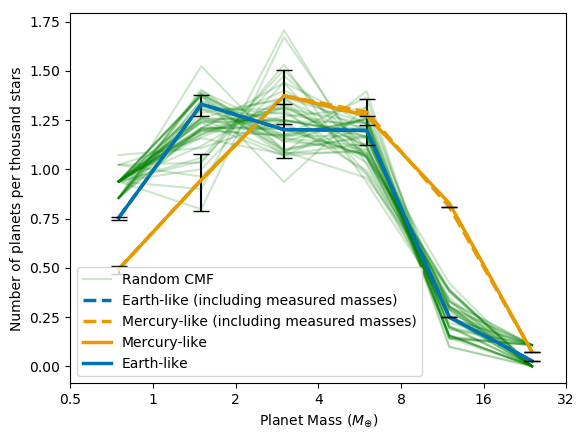

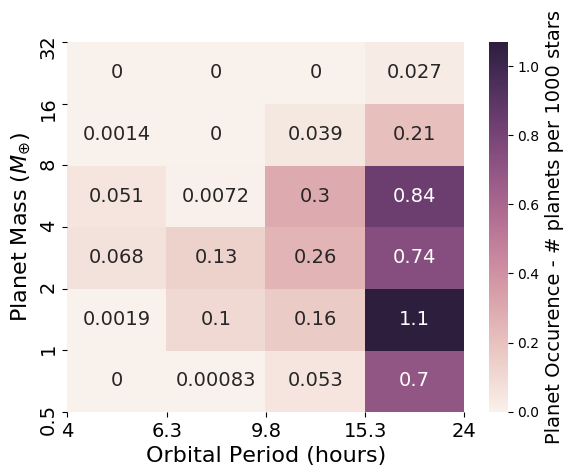

In [110]:

myblue = (0, .45, .70)


import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.pyplot as plt
earthsamples = []
earthperiodsamples = []
## open mass samples file, calculate occurrence rates, set up period array
with open('EarthlikeMassSamples.csv') as File:
     reader = csv.reader(File, delimiter=',')
     rownum = 0
     for row in reader:
         kepid2 = (int(row[0]))
         samplelist = []
         for i in range(len(row) - 1):
             samplelist.append(float(row[i]))
         for i in range(len(samplelist)):
             earthperiodsamples.append(float(per[kepid.index(kepid2)]))
         earthsamples = earthsamples + samplelist
         rownum += 1

mercurysamples = []
mercperiodsamples = []
## open mass samples file, calculate occurrence rates, set up period array
with open('MercuryLikeMassSamples.csv') as File:
     reader = csv.reader(File, delimiter=',')
     rownum = 0
     for row in reader:
         kepid2 = (int(row[0]))
         samplelist = []
         for i in range(len(row) - 1):
             samplelist.append(float(row[i]))
         for i in range(len(samplelist)):
             mercperiodsamples.append(float(per[kepid.index(kepid2)]))
         mercurysamples = mercurysamples + samplelist
         rownum += 1

randsamples = []
massrand = []
randperiodsamples = []
## open mass samples file, calculate occurrence rates, set up period array
with open('RandomCMFMassSamples.csv') as File:
     reader = csv.reader(File, delimiter=',')
     rownum = 0
     for row in reader:
         kepid2 = (int(row[0]))
         samplelist = []
         for i in range(len(row) - 1):
             samplelist.append(float(row[i]))
         for i in range(len(samplelist)):
             randperiodsamples.append(float(per[kepid.index(kepid2)]))
         massrand.append(np.percentile(list1, 50))
         randsamples = randsamples + samplelist
         rownum += 1

print("len massrand", len(massrand))

radbins = [0.5,(1/np.sqrt(2)),1,np.sqrt(2),2,2*np.sqrt(2),4]
massbins = [0.5,1,2,4,8,16,32]
perbins = [4,4*(6**0.25),4*np.sqrt(6),4*(6**0.75),24]

massarray = np.zeros((len(massbins)-1,len(perbins)-1))

massbinsflip = np.flip(massbins,0)

f = [(adivr[i]/numstars[i]) for i in range(0,len(kepid))]
f2 = [(1/numstars[i]) for i in range(0,len(kepid))]

## sum occurrence rate in bins

earthmasstransitarray = np.zeros((len(radbins)-1,len(massbins)-1))
mercmasstransitarray = np.zeros((len(radbins)-1,len(massbins)-1))
mercfreqarray = np.zeros((len(radbins)-1,len(massbins)-1))
earthfreqarray = np.zeros((len(radbins)-1,len(massbins)-1))

for i in range(len(massrand)):
    for j in range(len(perbins)-1):
        for k in range(len(massbins)-1):
            if (perbins[j] <= 24*randperiodsamples[i] <= perbins[j+1]) and (massbinsflip[k] >= massrand[i] >= massbinsflip[k+1]):
                massarray[k][j] += (f[i])
                
eartharray = np.zeros((len(massbins)-1,len(perbins)-1))
for i in range(len(earthperiodsamples)):
    for j in range(len(perbins)-1):
        for k in range(len(massbins)-1):
            if (perbins[j] <= 24*earthperiodsamples[i] <= perbins[j+1]) and (massbinsflip[k] >= earthsamples[i] >= massbinsflip[k+1]):
                earthmasstransitarray[k][j] += (f2[per.index(earthperiodsamples[i])])/1000
                earthfreqarray[k][j] += 1/1000
                if (earthperiodsamples[i] == kep10per):
                    eartharray[k][j] += ((f[per.index(earthperiodsamples[i])])/1000) * dist10.pdf(earthsamples[i]) * earth10norm
                elif (earthperiodsamples[i] == kep78per):
                    eartharray[k][j] += ((f[per.index(earthperiodsamples[i])])/1000) * dist78.pdf(earthsamples[i]) * earth78norm
                else:
                    eartharray[k][j] += (f[per.index(earthperiodsamples[i])])/1000
                          
mercuryarray = np.zeros((len(massbins)-1,len(perbins)-1))
for i in range(len(mercperiodsamples)):
    for j in range(len(perbins)-1):
        for k in range(len(massbins)-1):
            if (perbins[j] <= 24*mercperiodsamples[i] <= perbins[j+1]) and (massbinsflip[k] >= mercurysamples[i] >= massbinsflip[k+1]):
                mercmasstransitarray[k][j] += (f2[per.index(mercperiodsamples[i])])/1000
                mercfreqarray[k][j] += 1/1000
                if (mercperiodsamples[i] == kep10per):
                    mercuryarray[k][j] += (f[per.index(mercperiodsamples[i])])/1000 * dist10.pdf(mercurysamples[i]) * merc10norm
                elif (mercperiodsamples[i] == kep78per):
                    mercuryarray[k][j] += (f[per.index(mercperiodsamples[i])])/1000 * dist78.pdf(mercurysamples[i]) * merc78norm
                else:
                    mercuryarray[k][j] += (f[per.index(mercperiodsamples[i])])/1000

    
    
earthmasssum2 = np.zeros(len(massbins)-1)   
mercmasssum2 = np.zeros(len(massbins)-1) 
masssum = np.zeros(len(massbins)-1)  

merctransitsum = np.zeros(len(massbins)-1) 
earthtransitsum = np.zeros(len(massbins)-1) 

mercfreqsum = np.zeros(len(massbins)-1) 
earthfreqsum = np.zeros(len(massbins)-1) 
for j in range(len(massbins) - 1):
    for i in range(len(perbins)-1):
        masssum[j] += massarray[j][i]*1000
        earthmasssum2[j] += eartharray[j][i]*1000
        mercmasssum2[j] += mercuryarray[j][i]*1000
        earthtransitsum[j] += earthmasstransitarray[i][j] * 1000
        merctransitsum[j] += mercmasstransitarray[i][j] * 1000
        mercfreqsum[j] += mercfreqarray[i][j]
        earthfreqsum[j] += earthfreqarray[i][j]
        

massticks = np.zeros(len(massbins)-1) 
for i in range(len(massbins)-1):
    massticks[i] = np.log2((massbins[i+1] + massbins[i])/2)
         

       
earthwilsonhigh = np.zeros(len(massbins)-1,dtype = object) 
earthwilsonlow = np.zeros(len(massbins)-1,dtype = object) 
for i in range(len(massbins)-1):
    if earthtransitsum[i] == 0:
        earthwilsonhigh[i] = "N=0"
        earthwilsonlow[i] = "N=0"
    else:
        n = (earthfreqsum[i])/(earthtransitsum[i])
        if n == 0:
            earthwilsonhigh[i] = "n=0"
            earthwilsonlow[i] = "n=0"
        else:
            z = 0.41
            high = ((earthtransitsum[i] + (z**2)/(2*n))/(1+(z**2)/n)) + (z/(1+((z**2)/n)))*np.sqrt(((earthtransitsum[i]*(1-earthtransitsum[i]))/n)-((z**2)/(4*(n**2))))
            low = ((earthtransitsum[i] + (z**2)/(2*n))/(1+(z**2)/n)) - (z/(1+((z**2)/n)))*np.sqrt(((earthtransitsum[i]*(1-earthtransitsum[i]))/n)-((z**2)/(4*(n**2))))
            earthwilsonhigh[i] = ((earthmasssum2[i]/earthtransitsum[i])*high) - earthmasssum2[i]
            earthwilsonlow[i] = ((earthmasssum2[i]/earthtransitsum[i])*low) - earthmasssum2[i]

mercwilsonhigh = np.zeros(len(massbins)-1,dtype = object) 
mercwilsonlow = np.zeros(len(massbins)-1,dtype = object) 
for i in range(len(massbins)-1):
    if merctransitsum[i] == 0:
        mercwilsonhigh[i] = "N=0"
        mercwilsonlow[i] = "N=0"
    else:
        n = (mercfreqsum[i])/(merctransitsum[i])
        if n == 0:
            mercwilsonhigh[i] = "n=0"
            mercwilsonlow[i] = "n=0"
        else:
            z = 0.41
            high = ((merctransitsum[i] + (z**2)/(2*n))/(1+(z**2)/n)) + (z/(1+((z**2)/n)))*np.sqrt(((merctransitsum[i]*(1-merctransitsum[i]))/n)-((z**2)/(4*(n**2))))
            low = ((merctransitsum[i] + (z**2)/(2*n))/(1+(z**2)/n)) - (z/(1+((z**2)/n)))*np.sqrt(((merctransitsum[i]*(1-merctransitsum[i]))/n)-((z**2)/(4*(n**2))))
            mercwilsonhigh[i] = ((mercmasssum2[i]/merctransitsum[i])*high) - mercmasssum2[i]
            mercwilsonlow[i] = ((mercmasssum2[i]/merctransitsum[i])*low) - mercmasssum2[i]


eartherrorup = np.zeros(len(massbins)-1)
eartherrordown = np.zeros(len(massbins)-1)
mercerrorup = np.zeros(len(massbins)-1)
mercerrordown = np.zeros(len(massbins)-1)
for i in range(len(eartherrorup)):
    if earthwilsonhigh[i] == 'N=0':
        eartherrorup[i] = 0
        eartherrordown[i] = 0
        mercerrorup[i] = 0
        mercerrordown[i] = 0
    else:
        eartherrorup[i] = earthwilsonhigh[i]
        eartherrordown[i] = -1 * earthwilsonlow[i]
        mercerrorup[i] = mercwilsonhigh[i]
        mercerrordown[i] = -1 * mercwilsonlow[i]

        
mygold = (.9, .6, 0)
for o in range(0,49):
    massarray = np.zeros((len(massbins)-1,len(perbins)-1))
    massrand = []
    for j in meanearthradii:
        randomcmf = np.random.normal(0.33,0.1)
        while (randomcmf <= 0):
            randomcmf = np.random.normal(0.33,0.1)
        try:
            massrand.append(getmass((getpcmb(j, randomcmf), getpmaxhat(j, randomcmf))))
        except:
            print("couldn't interpolate", randomcmf)
    for i in range(len(massrand)):
        for j in range(len(perbins)-1):
            for k in range(len(massbins)-1):
                if (perbins[j] <= 24*randperiodsamples[i] <= perbins[j+1]) and (massbinsflip[k] >= massrand[i] >= massbinsflip[k+1]):
                    massarray[k][j] += (f[i])
    masssum = np.zeros(len(massbins)-1)  
    for j in range(len(massbins) - 1):
        for i in range(len(perbins)-1):
            masssum[j] += massarray[j][i]*1000
    plt.plot(massticks,np.flip(masssum,0), color = 'g', alpha = 0.2)
plt.plot(massticks,np.flip(masssum,0), color = 'g',label = 'Random CMF', alpha = 0.2)
plt.plot(massticks,np.flip(earthmasssum2,0), label = 'Earth-like (including measured masses)', color = myblue, linestyle='dashed', linewidth = 2.5)
plt.plot(massticks,np.flip(mercmasssum2,0), label = 'Mercury-like (including measured masses)', color = mygold, linestyle='dashed', linewidth = 2.5)
plt.plot(massticks,np.flip(mercmasssum,0), label = 'Mercury-like', color = mygold, linewidth = 2.5)
plt.plot(massticks,np.flip(earthmasssum,0), label = 'Earth-like', color = myblue, linewidth = 2.5)



plt.errorbar(massticks,np.flip(mercmasssum2,0), yerr = np.stack((mercerrorup,mercerrordown)), linestyle = 'None', ecolor = 'k', capsize = 6)
plt.errorbar(massticks,np.flip(earthmasssum2,0), yerr = np.stack((eartherrorup,eartherrordown)), linestyle = 'None', ecolor = 'k', capsize = 6)
plt.xlabel('Planet Mass ($M_{ \oplus}$)')
plt.ylabel('Number of planets per thousand stars')
plt.xticks([-1,0,1,2,3,4,5], [0.5,1,2,4,8,16,32])
plt.legend()

array = np.zeros((len(massbins)-1,len(perbins)-1))
freqarray = np.zeros((len(massbins)-1,len(perbins)-1))
for i in range(len(randperiodsamples)):
    for j in range(len(perbins)-1):
        for k in range(len(massbins)-1):
            if (perbins[j] <= 24*randperiodsamples[i] <= perbins[j+1]) and (massbinsflip[k] >= randmasssamples[i] >= massbinsflip[k+1]):
                array[k][j] += (f[per.index(randperiodsamples[i])])/1000
                freqarray[k][j] += 1

import seaborn as sns


fig, ax = plt.subplots()


ax = sns.heatmap(1000*eartharray, annot = True, annot_kws={"size": 14})
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels([4,6.3,9.8,15.3,24], fontsize = 14)
ax.set_yticks([0,1,2,3,4,5,6])
ax.set_yticklabels([0.5,1,2,4,8,16,32], fontsize = 14)
cbar = ax.collections[0].colorbar
cbar.set_label('Planet Occurence - # planets per 1000 stars', fontsize = 14)
plt.xlabel("Orbital Period (hours)", fontsize = 16)
plt.ylabel("Planet Mass ($M_{ \oplus}$)", fontsize = 16)

plt.show();

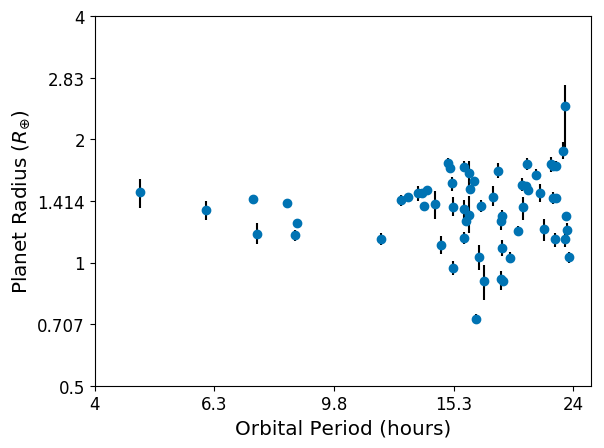

In [113]:
per2 = [24 * i for i in per]
down = [mean - value for mean, value in zip(meanearthradii, radiierrdown)]
up = [value - mean for mean, value in zip(meanearthradii, radiierrup)]

plt.loglog(per2,meanearthradii, 'o', basex = (6**0.25), basey = np.sqrt(2), color = myblue)
plt.errorbar(per2,meanearthradii, yerr = [down, up], linestyle = 'None', ecolor = 'k')
plt.yticks(radbins, [0.5,0.707,1,1.414,2,2.83,4], fontsize = 'large')
plt.xticks(perbins,[4,6.3,9.8,15.3,24], fontsize = 'large')
plt.xlabel("Orbital Period (hours)", fontsize = 'x-large')
plt.ylabel("Planet Radius ($R_{ \oplus}$)", fontsize = 'x-large')
##plt.title("Planet Radius vs. Orbital Period")
plt.show()

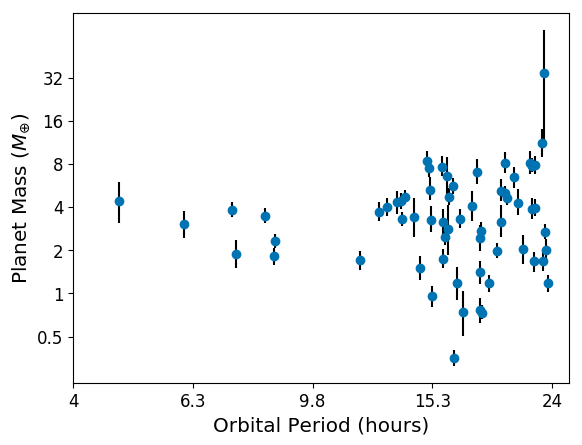

In [115]:
down = [mean - value for mean, value in zip(meanrandmasses, randerrdown)]
up = [value - mean for mean, value in zip(meanrandmasses, randerrup)]


plt.loglog(per2,meanrandmasses, 'o', basex = (6**0.25), basey = np.sqrt(2), color = myblue)
plt.errorbar(per2,meanrandmasses, yerr = [down, up], linestyle = 'None', ecolor = 'k')
plt.yticks(massbins, [0.5,1,2,4,8,16,32], fontsize = 'large')
plt.xticks(perbins,[4,6.3,9.8,15.3,24], fontsize = 'large')
plt.xlabel("Orbital Period (hours)", fontsize = 'x-large')
plt.ylabel("Planet Mass ($M_{ \oplus}$)", fontsize = 'x-large')
plt.show()

In [63]:
np.where(randerr == np.max(randerr))

(array([33]),)

In [64]:
mercerr[33]

nan

In [65]:
meanmercmasses[33]

nan

In [66]:
meanearthradii[33]

2.4109850247728475

In [67]:
earthradiierr[33]

0.39773068379205034

In [68]:
meanrandmasses[33]

33.686730486976124

In [69]:
randerr[33]

34.2250553421024

In [70]:
meanearthmasses[33]

34.60479146806121

In [71]:
eartherr[33]

32.68412625429588

In [82]:
koi[33]

3106